
# **Nvidia check para saber se CUDA e Drivers estão corretos**




In [ ]:
!nvidia-smi

Tue Jul 16 14:04:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Setup do Codigo**

**Importando pacotes**

In [ ]:
import os
import monai
import tempfile
from monai.apps import download_and_extract
from monai.bundle import ConfigParser
from monai.data import decollate_batch
from monai.handlers import MLFlowHandler
from monai.config import print_config
from monai.visualize.utils import blend_images

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage.measure import marching_cubes
import numpy as np

import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.25.2
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.2.1
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.14.1+cu117
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



**Cria um diretorio para receber os DICOMs**

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpbyd2ee1e


**Faz download dos DICOMs**

In [ ]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
print(data_dir)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

/tmp/tmpbyd2ee1e/Task09_Spleen


Task09_Spleen.tar: 1.50GB [01:00, 26.8MB/s]                            

2024-07-16 14:10:00,140 - INFO - Downloaded: /tmp/tmpbyd2ee1e/Task09_Spleen.tar


2024-07-16 14:10:02,982 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2024-07-16 14:10:02,983 - INFO - Writing into directory: /tmp/tmpbyd2ee1e.


**Elimina algumas imagens para diminuir o peso do processo**

In [ ]:
!find {data_dir}/imagesTs/spleen_* -type f | sort -zR | head -10 | tr '\n' '\0' | xargs -0 rm

**Instala o modelo do MONAI ZOO**

In [ ]:
monai.bundle.download(name="wholeBody_ct_segmentation", bundle_dir="./zoo_dir")

2024-07-16 14:11:55,417 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-07-16 14:11:55,419 - INFO - > name: 'wholeBody_ct_segmentation'
2024-07-16 14:11:55,421 - INFO - > bundle_dir: './zoo_dir'
2024-07-16 14:11:55,422 - INFO - > source: 'github'
2024-07-16 14:11:55,423 - INFO - > remove_prefix: 'monai_'
2024-07-16 14:11:55,424 - INFO - > progress: True
2024-07-16 14:11:55,425 - INFO - ---




wholeBody_ct_segmentation_v0.1.9.zip: 133MB [00:02, 54.7MB/s]                           

2024-07-16 14:11:58,480 - INFO - Downloaded: zoo_dir/wholeBody_ct_segmentation_v0.1.9.zip
2024-07-16 14:11:58,482 - INFO - Expected md5 is None, skip md5 check for file zoo_dir/wholeBody_ct_segmentation_v0.1.9.zip.
2024-07-16 14:11:58,484 - INFO - Writing into directory: zoo_dir.


**Avaliação do Bundle**

In [ ]:
!python -m monai.bundle run evaluating \
    --meta_file "./zoo_dir/wholeBody_ct_segmentation/configs/metadata.json" \
    --config_file "./zoo_dir/wholeBody_ct_segmentation/configs/inference.json" \
    --logging_file "./zoo_dir/wholeBody_ct_segmentation/configs/logging.conf" \
    --dataset_dir "{data_dir}" \
    --bundle_root "./zoo_dir/wholeBody_ct_segmentation"

2024-07-16 14:12:19,217 - INFO - --- input summary of monai.bundle.scripts.run ---
2024-07-16 14:12:19,217 - INFO - > runner_id: 'evaluating'
2024-07-16 14:12:19,217 - INFO - > meta_file: './zoo_dir/wholeBody_ct_segmentation/configs/metadata.json'
2024-07-16 14:12:19,217 - INFO - > config_file: './zoo_dir/wholeBody_ct_segmentation/configs/inference.json'
2024-07-16 14:12:19,217 - INFO - > logging_file: './zoo_dir/wholeBody_ct_segmentation/configs/logging.conf'
2024-07-16 14:12:19,218 - INFO - > dataset_dir: '/tmp/tmpbyd2ee1e/Task09_Spleen'
2024-07-16 14:12:19,218 - INFO - > bundle_root: './zoo_dir/wholeBody_ct_segmentation'
2024-07-16 14:12:19,218 - INFO - ---


2024-07-16 14:12:19,218 - INFO - set logging properties based on config: ./zoo_dir/wholeBody_ct_segmentation/configs/logging.conf.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/monai/bundle/reference_resolver.py", line 122, in _resolve_one_item
    item = look_up_option(id, self.items, print

# **IMPORTANTE!!!**

:VÁ EM ARQUIVOS **zoo_dir/wholeBody_ct_segmentation/configs/inference** e troque o **highres** de true para **FALSE**

# **Separação da imagem**

**Define a Paste de resultados**

In [ ]:
output_dir = os.path.abspath("./monai_results")

**Define o dispositivo para o Pytorch**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Define as configurações do modelo**

In [ ]:
model_config_file = os.path.join("./zoo_dir", "wholeBody_ct_segmentation", "configs", "inference.json")
model_config = ConfigParser()
model_config.read_config(model_config_file)

model_config["bundle_root"] = "./zoo_dir"
model_config["output_dir"] = output_dir
model_config["dataset_dir"] = data_dir

**Define o Checkpoint**

Checkpoint nada mais é que a versão do modelo, no workshop eles falam que "model.pt" é a melhor versão da maioria dos modelos

In [ ]:
checkpoint = os.path.join("./zoo_dir", "wholeBody_ct_segmentation", "models", "model_lowres.pt")

**Define funções do modelo**

In [ ]:
preprocessing = model_config.get_parsed_content("preprocessing")
model = model_config.get_parsed_content("network").to(device)
inferer = model_config.get_parsed_content("inferer")
postprocessing = model_config.get_parsed_content("postprocessing")
dataloader = model_config.get_parsed_content("dataloader")

**Carrega o estado do modelo e ativa o eval mode**

In [ ]:
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

**Checar memoria alocada**

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   73442 KB |  146885 KB |  146885 KB |   73442 KB |\n|       from large pool |   69120 KB |  138240 KB |  138240 KB |   69120 KB |\n|       from small pool |    4322 KB |    8645 KB |    8645 KB |    4322 KB |\n|---------------------------------------------------------------------------|\n| Active memory         |   73442 KB |  146885 KB |  146885 KB |   73442 KB |\n|       from large pool |   69120 KB |  138240 KB |

**Limpa o cache e limita o max slit size, pq o processo para o corpo todo é pesado**

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.cuda.set_device(device)
torch.cuda.empty_cache()

model.groupnorm1 = torch.nn.GroupNorm(num_groups=8, num_channels=64)
torch.cuda.set_per_process_memory_fraction(0.5, 0)

**Roda a função inferer, que é responsavel pela aplicação da segmentação**

In [ ]:
d = next(iter(dataloader))
images = d["image"].to(device)
images.size()

torch.Size([1, 1, 113, 113, 143])

O tamanho [:, 20:100, 20:100, 20:100] foi escolhido pois reduz o DICOM (fazendo o código rodar mais facilmente) e sem perder partes do corpo ao só tirar espaços vazios

In [ ]:
img = images[:, :, 20:100, 20:100, 20:100]
img.size()

torch.Size([1, 1, 80, 80, 80])

In [ ]:
d["pred"] = inferer(img, network=model)

**Separa a imagens em ORIGINAL, PREDICTION e MAP**

In [ ]:
orig_img = d['image'][0]
reduced_img = orig_img[:, 20:100, 20:100, 20:100]

pred_img = d['pred'].argmax(1).cpu()

# print(reduced_img.shape)
# print(pred_img.shape)

map_image = reduced_img + pred_img
print(map_image.shape)

torch.Size([1, 80, 80, 80])


**Plot das Imagens**

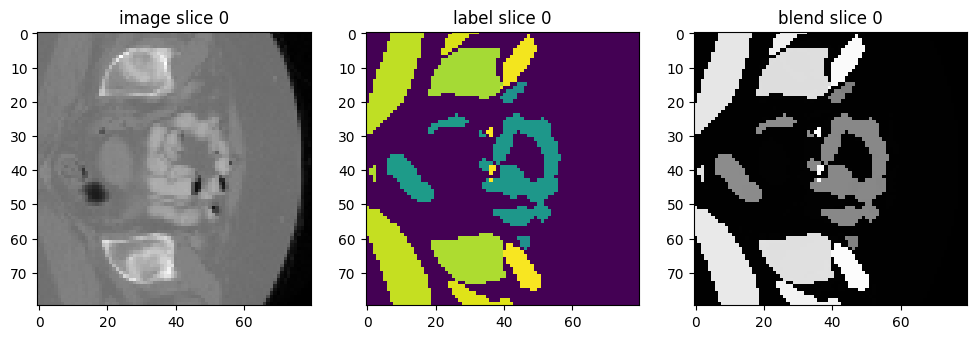

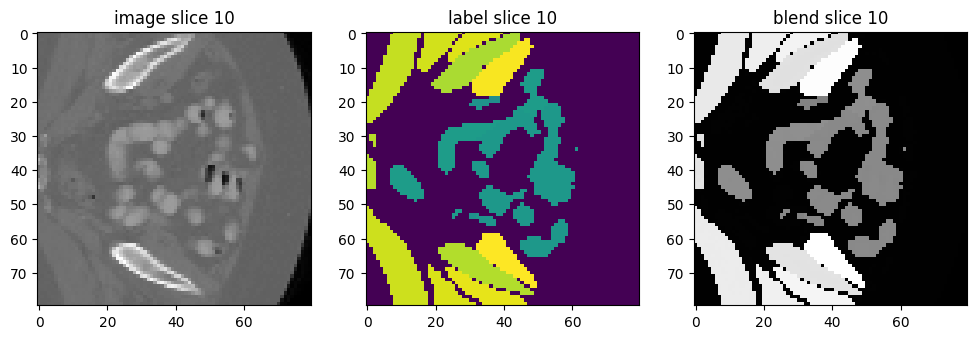

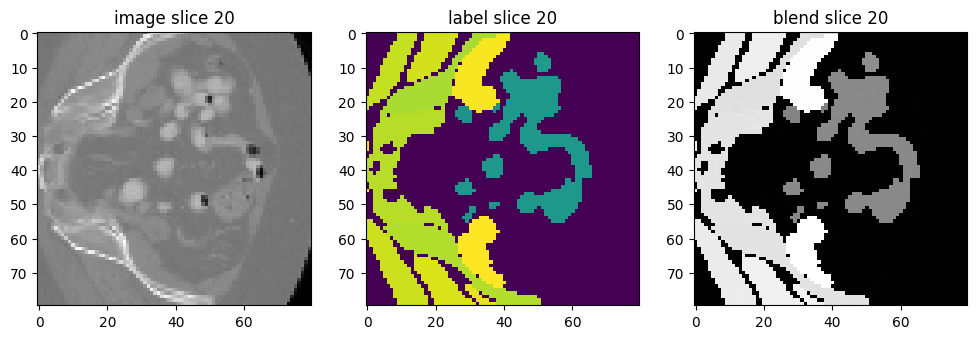

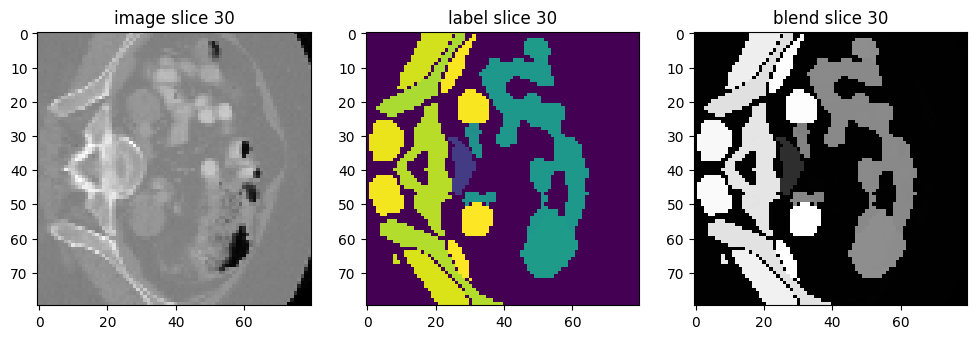

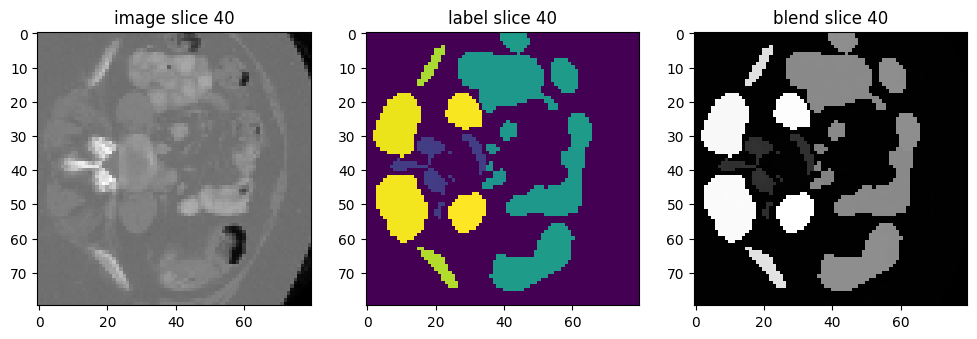

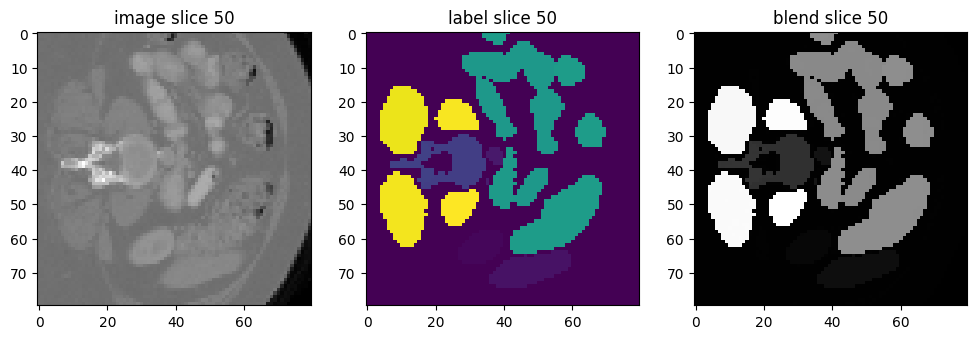

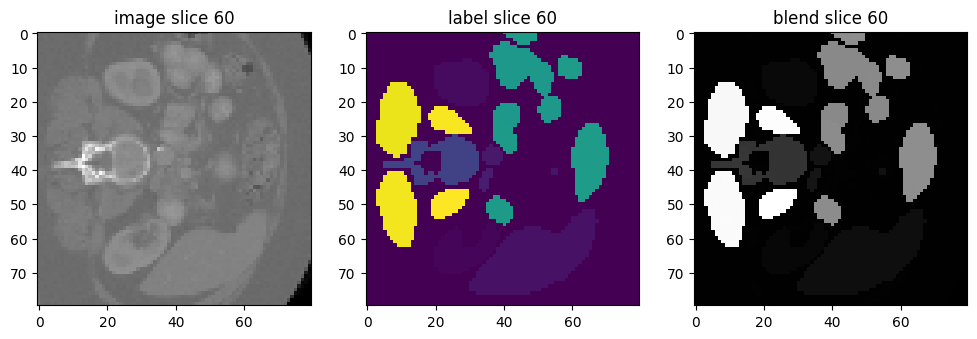

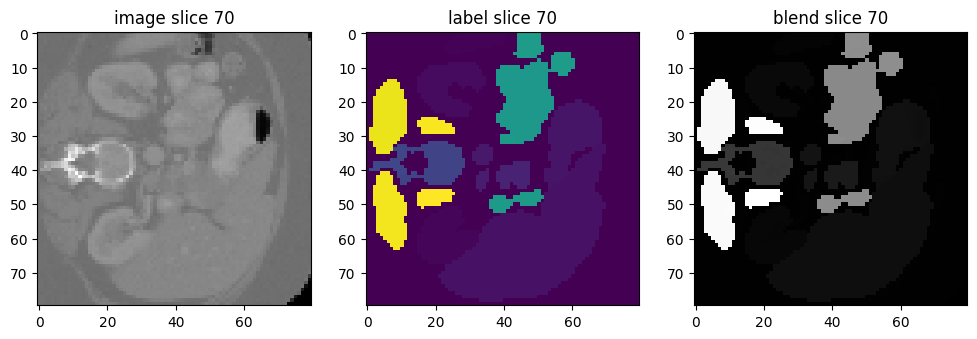

In [ ]:
slices = map_image.shape[-1]

for i in range(0, int(slices / 10)):
    slice_index = 10 * i

    plt.figure("blend image and label", (12, 4))

    plt.subplot(1, 3, 1)
    plt.title(f"image slice {slice_index}")
    plt.imshow(reduced_img[0, :, :, slice_index], cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title(f"label slice {slice_index}")
    plt.imshow(pred_img[0, :, :, slice_index])

    map_image = (reduced_img + d['pred'].argmax(1).cpu())

    plt.subplot(1, 3, 3)
    plt.title(f"blend slice {slice_index}")
    plt.imshow(map_image[0, :, :, slice_index], cmap="gray")

    plt.show()